In [1]:
# Wrangling
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import json
import wrangle

# Visualizing
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from sklearn.model_selection import learning_curve

from sklearn.cluster import KMeans

In [2]:
df = wrangle.acquire_beer_classification()


In [3]:
df.shape

(30140, 28)

In [4]:
df = wrangle.prepare_beer(df)

In [5]:
df['abv'] = df['abv'].astype(float)
df['ibu'] = df['ibu'].astype(float)

#remove outliers for abv
#dropped 110
df = df.loc[df["abv"] <=20]
df = df.loc[df["abv"] > 0.5]
df = df.loc[df["ibu"] > 1]

# will change these values later to equal high_value eliminating now
df = df.loc[df['ibu'] < 150]
df.shape

(26033, 41)

In [6]:
df.shape

(26033, 41)

In [7]:
df.columns

Index(['id', 'name', 'nameDisplay', 'abv', 'styleId', 'statusDisplay', 'style',
       'description', 'ibu', 'srm', 'ibu_min', 'ibu_max', 'abv_min', 'abv_max',
       'srm_min', 'srm_max', 'og_min', 'fg_min', 'fg_max', 'category_id',
       'short_name', 'srm_avg', 'ibu_avg', 'abv_avg', 'sour', 'fruit_des',
       'wheat_des', 'smoke_des', 'chili_des', 'mead_des', 'lager_des', 'BBL',
       'american_hop', 'piney_flavor', 'belgian', 'imperial', 'honey',
       'esters', 'bitterness', 'oak', 'style_collapsed'],
      dtype='object')

TIME TO SPLIT

In [8]:
def split_data(df):
    '''
    Takes in a dataframe and returns train, validate, and test subset dataframes. 
    '''
    train, test = train_test_split(df, test_size = .2, random_state = 222)
    train, validate = train_test_split(train, test_size = .3, random_state = 222)
    return train, validate, test

In [9]:
train, validate, test = split_data(df)

In [10]:
train.shape, validate.shape, test.shape

((14578, 41), (6248, 41), (5207, 41))

check dtypes

In [11]:
train.dtypes

id                  object
name                object
nameDisplay         object
abv                float64
styleId              int64
statusDisplay       object
style               object
description         object
ibu                float64
srm                float64
ibu_min            float64
ibu_max            float64
abv_min            float64
abv_max            float64
srm_min            float64
srm_max            float64
og_min             float64
fg_min             float64
fg_max             float64
category_id          int64
short_name          object
srm_avg            float64
ibu_avg            float64
abv_avg            float64
sour                  bool
fruit_des             bool
wheat_des             bool
smoke_des             bool
chili_des             bool
mead_des              bool
lager_des             bool
BBL                   bool
american_hop          bool
piney_flavor          bool
belgian               bool
imperial              bool
honey                 bool
e

In [12]:
#would think we need to make ibu and abv as a float
train['ibu'] = train['ibu'].astype(float)
train['abv'] = train['abv'].astype(float)

In [13]:
#think of what to scale: ibu, srm, abv
from sklearn.preprocessing import MinMaxScaler

In [14]:
def min_max_scaler(train, validate, test):
    '''
    Uses the train & test datasets created by the split_my_data function
    Returns 3 items: mm_scaler, train_scaled_mm, test_scaled_mm
    This is a linear transformation. Values will lie between 0 and 1
    '''
    num_vars = list(train.select_dtypes('number').columns)
    scaler = MinMaxScaler(copy=True, feature_range=(0, 1))
    train[num_vars] = scaler.fit_transform(train[num_vars])
    validate[num_vars] = scaler.transform(validate[num_vars])
    test[num_vars] = scaler.transform(test[num_vars])
    return scaler, train, validate, test

In [15]:
def scale(train, validate, test):
    '''
    Uses the train & test datasets created by the split_my_data function
    Returns 3 items: mm_scaler, train_scaled_mm, test_scaled_mm
    This is a linear transformation. Values will lie between 0 and 1
    '''
    scaled_vars = ['ibu', 'srm', 'abv']
    scaled_column_names = ['scaled_' + i for i in scaled_vars]
    #num_vars = list(X_train.select_dtypes('number').columns)
    scaler = MinMaxScaler(copy=True, feature_range=(0, 1))
    #df[scaled_column_names] = scaler.fit_transform(df[scaled_vars])
    train[scaled_column_names] = scaler.fit_transform(train[scaled_vars])
    validate[scaled_column_names] = scaler.transform(validate[scaled_vars])
    test[scaled_column_names] = scaler.transform(test[scaled_vars])
    return train, validate, test

In [16]:
#test scale on values
train, validate, test = scale(train, validate, test)

In [17]:
#checking
train.dtypes

id                  object
name                object
nameDisplay         object
abv                float64
styleId              int64
statusDisplay       object
style               object
description         object
ibu                float64
srm                float64
ibu_min            float64
ibu_max            float64
abv_min            float64
abv_max            float64
srm_min            float64
srm_max            float64
og_min             float64
fg_min             float64
fg_max             float64
category_id          int64
short_name          object
srm_avg            float64
ibu_avg            float64
abv_avg            float64
sour                  bool
fruit_des             bool
wheat_des             bool
smoke_des             bool
chili_des             bool
mead_des              bool
lager_des             bool
BBL                   bool
american_hop          bool
piney_flavor          bool
belgian               bool
imperial              bool
honey                 bool
e

In [18]:
# lets run find k function
def find_k(X_train, cluster_vars, k_range):
    sse = []
    for k in k_range:
        kmeans = KMeans(n_clusters=k)

        # X[0] is our X_train dataframe..the first dataframe in the list of dataframes stored in X. 
        kmeans.fit(X_train[cluster_vars])

        # inertia: Sum of squared distances of samples to their closest cluster center.
        sse.append(kmeans.inertia_) 

    # compute the difference from one k to the next
    delta = [round(sse[i] - sse[i+1],0) for i in range(len(sse)-1)]

    # compute the percent difference from one k to the next
    pct_delta = [round(((sse[i] - sse[i+1])/sse[i])*100, 1) for i in range(len(sse)-1)]

    # create a dataframe with all of our metrics to compare them across values of k: SSE, delta, pct_delta
    k_comparisons_df = pd.DataFrame(dict(k=k_range[0:-1], 
                             sse=sse[0:-1], 
                             delta=delta, 
                             pct_delta=pct_delta))

    # plot k with inertia
    plt.plot(k_comparisons_df.k, k_comparisons_df.sse, 'bx-')
    plt.xlabel('k')
    plt.ylabel('SSE')
    plt.title('The Elbow Method to find the optimal k\nFor which k values do we see large decreases in SSE?')
    plt.show()

    # plot k with pct_delta
    plt.plot(k_comparisons_df.k, k_comparisons_df.pct_delta, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Percent Change')
    plt.title('For which k values are we seeing increased changes (%) in SSE?')
    plt.show()

    # plot k with delta
    plt.plot(k_comparisons_df.k, k_comparisons_df.delta, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Absolute Change in SSE')
    plt.title('For which k values are we seeing increased changes (absolute) in SSE?')
    plt.show()

    return k_comparisons_df

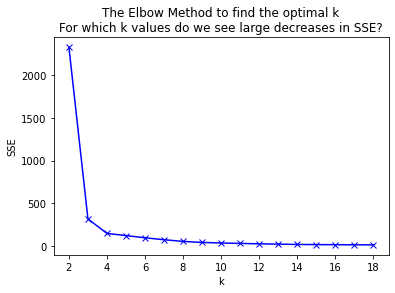

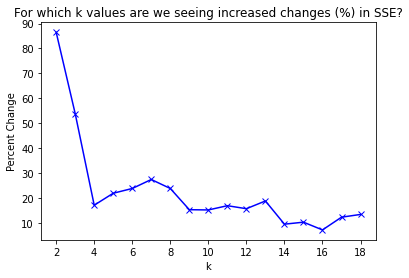

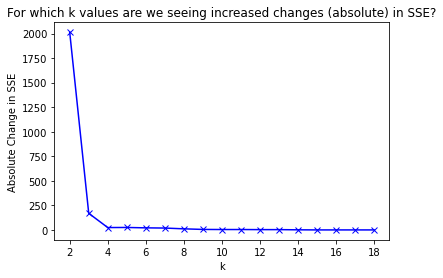

,k,sse,delta,pct_delta
0,2,2327.636259,2013.0,86.5
1,3,315.104446,170.0,53.9
2,4,145.123577,25.0,17.2
3,5,120.184982,26.0,22.0
4,6,93.785614,22.0,23.9
5,7,71.403113,20.0,27.5
6,8,51.749116,12.0,23.9
7,9,39.371447,6.0,15.4
8,10,33.323407,5.0,15.3
9,11,28.237825,5.0,17.0


In [19]:
#Scaled IBU isn't giving me a good K
cluster_vars = ['scaled_ibu', 'american_hop', 'bitterness', 'piney_flavor']
cluster_name = 'bitterness'
k_range = range(2,20)
find_k(train, cluster_vars, k_range)

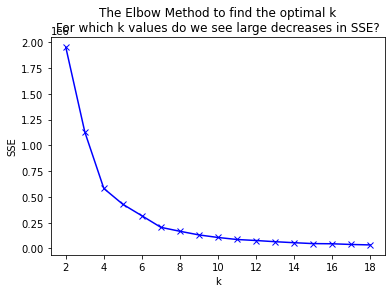

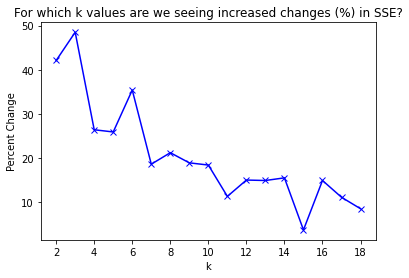

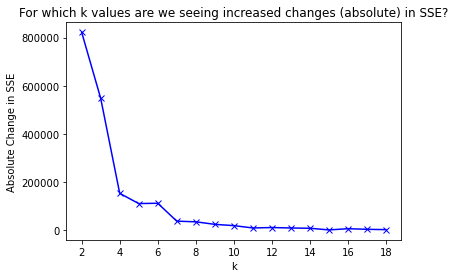

,k,sse,delta,pct_delta
0,2,1.952331e+06,822335.0,42.1
1,3,1.129995e+06,548035.0,48.5
2,4,5.819601e+05,153499.0,26.4
3,5,4.284613e+05,111169.0,25.9
4,6,3.172923e+05,112404.0,35.4
5,7,2.048880e+05,38105.0,18.6
6,8,1.667828e+05,35385.0,21.2
7,9,1.313978e+05,24784.0,18.9
8,10,1.066133e+05,19598.0,18.4
9,11,8.701496e+04,9800.0,11.3


In [20]:
cluster_vars = ['ibu', 'american_hop', 'bitterness', 'piney_flavor']
cluster_name = 'bitterness'
k_range = range(2,20)
find_k(train, cluster_vars, k_range)
#k = 7?

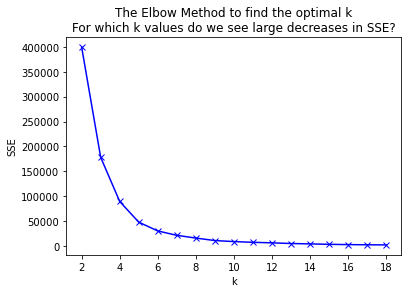

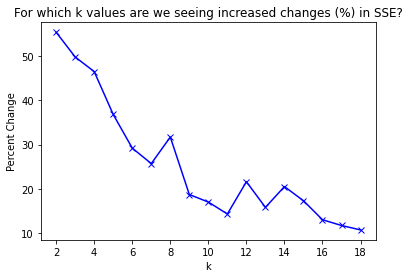

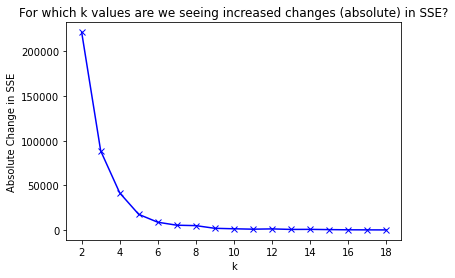

,k,sse,delta,pct_delta
0,2,399263.404127,221264.0,55.4
1,3,177999.284050,88611.0,49.8
2,4,89387.964000,41597.0,46.5
3,5,47791.413270,17608.0,36.8
4,6,30183.863818,8828.0,29.2
5,7,21355.419418,5494.0,25.7
6,8,15861.527463,5023.0,31.7
7,9,10838.646269,2024.0,18.7
8,10,8815.098948,1498.0,17.0
9,11,7317.365163,1044.0,14.3


In [21]:
cluster_vars = ['srm']
cluster_name = 'bitterness'
k_range = range(2,20)
find_k(train, cluster_vars, k_range)

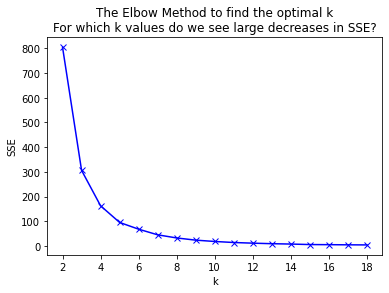

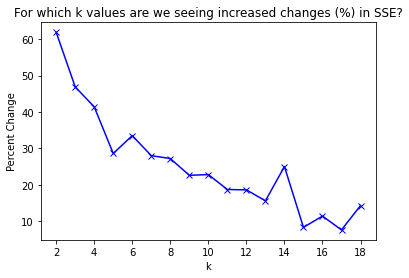

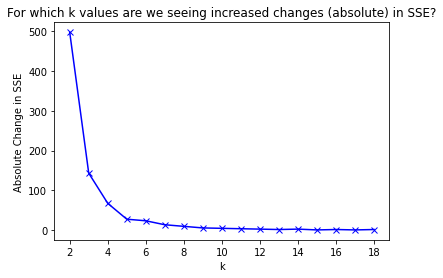

,k,sse,delta,pct_delta
0,2,804.409190,498.0,61.9
1,3,306.221298,143.0,46.9
2,4,162.726483,67.0,41.4
3,5,95.404279,27.0,28.6
4,6,68.147955,23.0,33.5
5,7,45.331935,13.0,28.0
6,8,32.651705,9.0,27.2
7,9,23.775108,5.0,22.6
8,10,18.411436,4.0,22.8
9,11,14.222272,3.0,18.7


In [22]:
cluster_vars = ['scaled_srm', 'mead_des']
cluster_name = 'srm'
k_range = range(2,20)
find_k(train, cluster_vars, k_range)
#k = 6

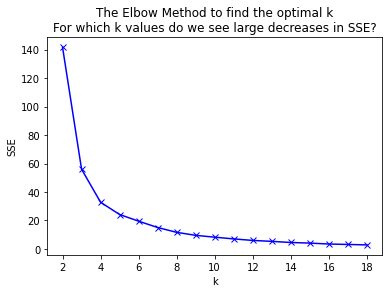

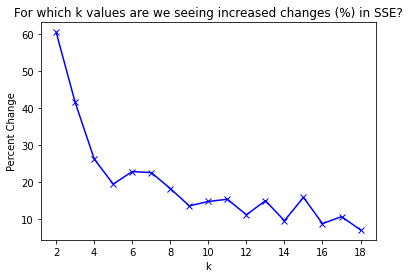

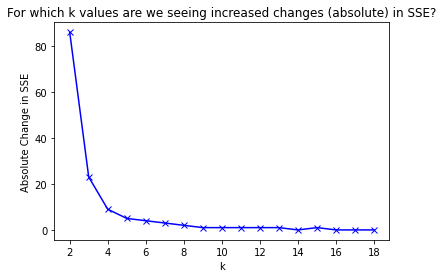

In [23]:
cluster_vars = ['scaled_abv', 'imperial']
cluster_name = 'abv'
k_range = range(2,20)
find_k(train, cluster_vars, k_range)
k = 7

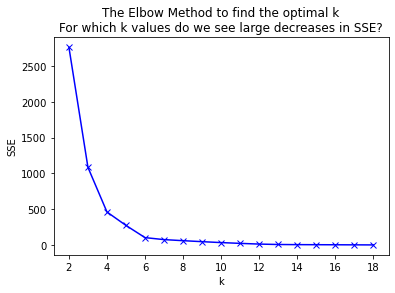

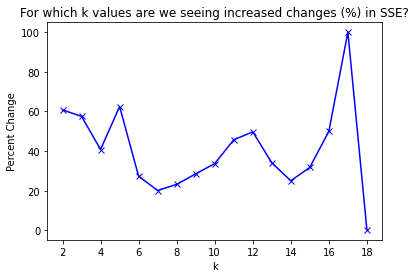

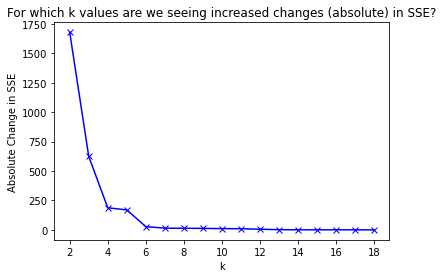

,k,sse,delta,pct_delta
0,2,2.763588e+03,1679.0,60.8
1,3,1.084433e+03,624.0,57.5
2,4,4.604341e+02,188.0,40.8
3,5,2.723995e+02,170.0,62.5
4,6,1.020727e+02,28.0,27.3
5,7,7.416986e+01,15.0,20.1
6,8,5.929095e+01,14.0,23.2
7,9,4.550910e+01,13.0,28.5
8,10,3.255891e+01,11.0,33.7
9,11,2.159250e+01,10.0,45.7


In [24]:
cluster_vars = ['fruit_des', 'wheat_des', 'smoke_des', 'chili_des', 'BBL', 'honey']
cluster_name = 'flavor'
k_range = range(2,20)
find_k(train, cluster_vars, k_range)

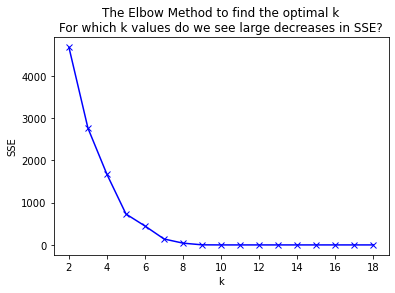

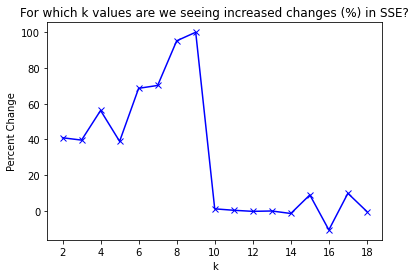

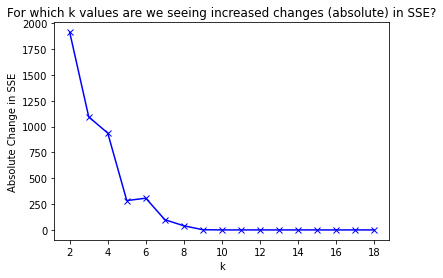

,k,sse,delta,pct_delta
0,2,4.674838e+03,1913.0,40.9
1,3,2.761725e+03,1094.0,39.6
2,4,1.667855e+03,937.0,56.2
3,5,7.307376e+02,284.0,38.9
4,6,4.468253e+02,307.0,68.6
5,7,1.402439e+02,99.0,70.2
6,8,4.172465e+01,40.0,95.2
7,9,1.998667e+00,2.0,100.0
8,10,1.014310e-25,0.0,1.1
9,11,1.003230e-25,0.0,0.3


In [25]:
cluster_vars = ['esters', 'oak', 'lager_des', 'belgian']
cluster_name = 'yeast'
k_range = range(2,20)
find_k(train, cluster_vars, k_range)

In [26]:
train.dtypes

id                  object
name                object
nameDisplay         object
abv                float64
styleId              int64
statusDisplay       object
style               object
description         object
ibu                float64
srm                float64
ibu_min            float64
ibu_max            float64
abv_min            float64
abv_max            float64
srm_min            float64
srm_max            float64
og_min             float64
fg_min             float64
fg_max             float64
category_id          int64
short_name          object
srm_avg            float64
ibu_avg            float64
abv_avg            float64
sour                  bool
fruit_des             bool
wheat_des             bool
smoke_des             bool
chili_des             bool
mead_des              bool
lager_des             bool
BBL                   bool
american_hop          bool
piney_flavor          bool
belgian               bool
imperial              bool
honey                 bool
e

In [27]:
# df['BBL'] = df['BBL'].astype(bool)
# df['lager_des'] = df['lager_des'].astype(bool)
# df['mead_des'] = df['mead_des'].astype(bool)
# df['chili_des'] = df['chili_des'].astype(bool)
# df['smoke_des'] = df['smoke_des'].astype(bool)
# df['wheat_des'] = f['wheat_des'].astype(bool)
# df['fruit_des'] = df['fruit_des'].astype(bool)
# df['sour'] = df['sour'].astype(bool)


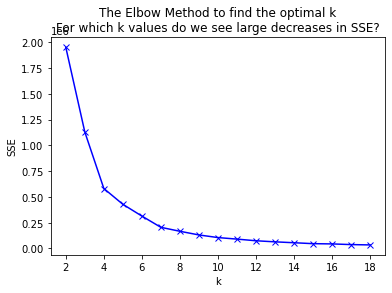

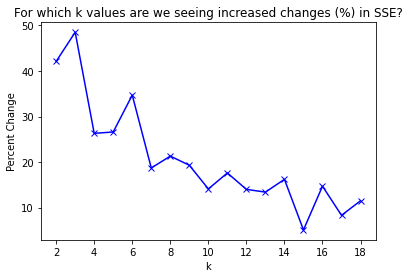

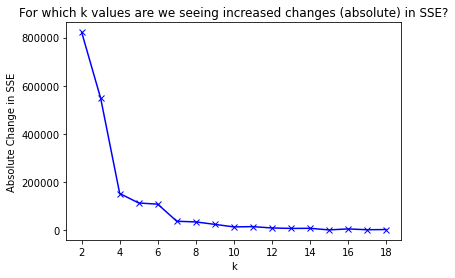

,k,sse,delta,pct_delta
0,2,1.952327e+06,822332.0,42.1
1,3,1.129995e+06,548035.0,48.5
2,4,5.819601e+05,153328.0,26.3
3,5,4.286320e+05,114102.0,26.6
4,6,3.145303e+05,109179.0,34.7
5,7,2.053512e+05,38339.0,18.7
6,8,1.670124e+05,35609.0,21.3
7,9,1.314032e+05,25385.0,19.3
8,10,1.060177e+05,14961.0,14.1
9,11,9.105702e+04,16045.0,17.6


In [28]:
cluster_vars = ['ibu', 'american_hop', 'bitterness', 'piney_flavor']
cluster_name = 'bitterness'
k_range = range(2,20)
find_k(train, cluster_vars, k_range)

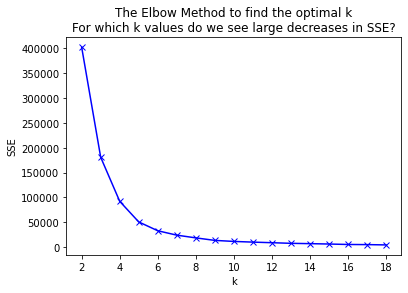

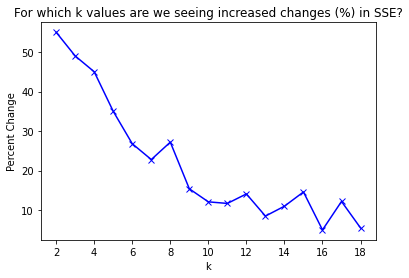

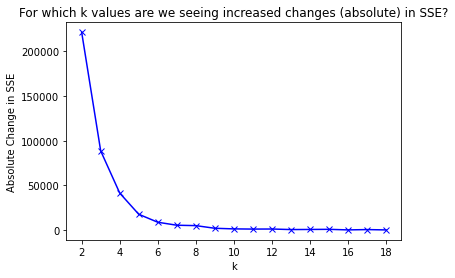

,k,sse,delta,pct_delta
0,2,401979.289015,221266.0,55.0
1,3,180713.696519,88612.0,49.0
2,4,92101.759678,41459.0,45.0
3,5,50643.021707,17745.0,35.0
4,6,32897.685933,8829.0,26.8
5,7,24068.824340,5494.0,22.8
6,8,18574.920657,5044.0,27.2
7,9,13530.696277,2082.0,15.4
8,10,11448.339929,1390.0,12.1
9,11,10058.760968,1180.0,11.7


In [29]:
cluster_vars = ['srm', 'mead_des']
cluster_name = 'srmcluster'
k_range = range(2,20)
find_k(train, cluster_vars, k_range)

In [30]:
k=6
def create_clusters(X_train, k, cluster_vars):
    # create kmean object
    kmeans = KMeans(n_clusters=k, random_state = 13)

    # fit to train and assign cluster ids to observations
    kmeans.fit(X_train[cluster_vars])

    return kmeans

In [31]:
kmeans = create_clusters(train, k, cluster_vars)


In [32]:
def get_centroids(kmeans, cluster_vars, cluster_name):
    # get the centroids for each distinct cluster...

    centroid_col_names = ['centroid_' + i for i in cluster_vars]

    centroid_df = pd.DataFrame(kmeans.cluster_centers_, 
                               columns=centroid_col_names).reset_index().rename(columns={'index': cluster_name})

    return centroid_df

In [33]:
centroid_df = get_centroids(kmeans, cluster_vars, cluster_name)


In [34]:
centroid_df.head(7)


,srmcluster,centroid_srm,centroid_mead_des
0,0,40.094602,0.225376
1,1,9.713559,0.254237
2,2,27.772854,0.247034
3,3,4.692409,0.236144
4,4,20.426761,0.273239
5,5,14.630048,0.264887


In [35]:
df.ibu.value_counts()

60.0     2262
30.0     1605
35.0     1441
25.0     1383
20.0     1377
         ... 
55.3        1
92.2        1
29.1        1
122.9       1
131.0       1
Name: ibu, Length: 469, dtype: int64

In [36]:
#think of what to scale: ibu, srm, abv
from sklearn.preprocessing import MinMaxScaler

In [37]:
def scale(train, validate, test):
    '''
    Uses the train & test datasets created by the split_my_data function
    Returns 3 items: mm_scaler, train_scaled_mm, test_scaled_mm
    This is a linear transformations. Values will lie between 0 and 1
    '''
    scaled_vars = ['ibu', 'srm', 'abv']
    scaled_column_names = ['scaled_' + i for i in scaled_vars]
    #num_vars = list(X_train.select_dtypes('number').columns)
    scaler = MinMaxScaler(copy=True, feature_range=(0, 1))
    df[scaled_column_names] = scaler.fit_transform(df[scaled_vars])
    train[scaled_column_names] = scaler.fit_transform(train[scaled_vars])
    validate[scaled_column_names] = scaler.transform(validate[scaled_vars])
    test[scaled_column_names] = scaler.transform(test[scaled_vars])
    return train, validate, test

In [38]:
train, validate, test = scale(train, validate, test)

In [39]:
# good values to scale as they are my top 3 moving forward
train.head()

,id,name,nameDisplay,abv,styleId,statusDisplay,style,description,ibu,srm,...,belgian,imperial,honey,esters,bitterness,oak,style_collapsed,scaled_ibu,scaled_srm,scaled_abv
41,e1XxuT,Vindictive,Vindictive (2016),14.9,43,Verified,"{'id': 43, 'categoryId': 3, 'category': {'id':...",If some of the best wines are blends of severa...,65.0,40.0,...,False,True,False,False,True,False,Stout,0.435190,0.787879,0.751351
46,rcJsik,Northern Logger,Northern Logger,4.9,36,Verified,"{'id': 36, 'categoryId': 3, 'category': {'id':...",An easy drinking beer brewed with Northern cli...,17.0,5.0,...,False,False,False,True,False,False,Blonde,0.108552,0.080808,0.210811
19,5qJzoJ,American Velvet,American Velvet,4.5,20,Verified,"{'id': 20, 'categoryId': 1, 'category': {'id':...",NaN,20.0,40.0,...,False,False,False,False,False,False,Stout,0.128967,0.787879,0.189189
36,Sponwn,Pawpaw La Maison,Pawpaw La Maison,7.5,72,Verified,"{'id': 72, 'categoryId': 5, 'category': {'id':...",This unique special release features our house...,25.0,9.0,...,True,False,False,False,True,False,Saison,0.162992,0.161616,0.351351
7,TkCJXL,Black Dolphin,Black Dolphin,8.3,43,Verified,"{'id': 43, 'categoryId': 3, 'category': {'id':...",NaN,65.0,40.0,...,False,True,False,False,True,False,Stout,0.435190,0.787879,0.394595


In [40]:
train.columns

Index(['id', 'name', 'nameDisplay', 'abv', 'styleId', 'statusDisplay', 'style',
       'description', 'ibu', 'srm', 'ibu_min', 'ibu_max', 'abv_min', 'abv_max',
       'srm_min', 'srm_max', 'og_min', 'fg_min', 'fg_max', 'category_id',
       'short_name', 'srm_avg', 'ibu_avg', 'abv_avg', 'sour', 'fruit_des',
       'wheat_des', 'smoke_des', 'chili_des', 'mead_des', 'lager_des', 'BBL',
       'american_hop', 'piney_flavor', 'belgian', 'imperial', 'honey',
       'esters', 'bitterness', 'oak', 'style_collapsed', 'scaled_ibu',
       'scaled_srm', 'scaled_abv'],
      dtype='object')

In [45]:
k = 6
cluster_vars = ['ibu', 'american_hop', 'bitterness', 'piney_flavor']
cluster_name = 'bitterness'

,id,name,nameDisplay,abv,styleId,statusDisplay,style,description,ibu,srm,...,belgian,imperial,honey,esters,bitterness,oak,style_collapsed,scaled_ibu,scaled_srm,scaled_abv
41,e1XxuT,Vindictive,Vindictive (2016),14.9,43,Verified,"{'id': 43, 'categoryId': 3, 'category': {'id':...",If some of the best wines are blends of severa...,65.0,40.0,...,False,True,False,False,True,False,Stout,0.435190,0.787879,0.751351
46,rcJsik,Northern Logger,Northern Logger,4.9,36,Verified,"{'id': 36, 'categoryId': 3, 'category': {'id':...",An easy drinking beer brewed with Northern cli...,17.0,5.0,...,False,False,False,True,False,False,Blonde,0.108552,0.080808,0.210811
19,5qJzoJ,American Velvet,American Velvet,4.5,20,Verified,"{'id': 20, 'categoryId': 1, 'category': {'id':...",NaN,20.0,40.0,...,False,False,False,False,False,False,Stout,0.128967,0.787879,0.189189
36,Sponwn,Pawpaw La Maison,Pawpaw La Maison,7.5,72,Verified,"{'id': 72, 'categoryId': 5, 'category': {'id':...",This unique special release features our house...,25.0,9.0,...,True,False,False,False,True,False,Saison,0.162992,0.161616,0.351351
7,TkCJXL,Black Dolphin,Black Dolphin,8.3,43,Verified,"{'id': 43, 'categoryId': 3, 'category': {'id':...",NaN,65.0,40.0,...,False,True,False,False,True,False,Stout,0.435190,0.787879,0.394595


In [47]:
k=7
def create_clusters(train, k, cluster_vars):
    # create kmean object
    kmeans = KMeans(n_clusters=k, random_state = 13)

    # fit to train and assign cluster ids to observations
    kmeans.fit(train[cluster_vars])

    return kmeans

In [48]:
kmeans = create_clusters(train, k, cluster_vars)

In [49]:
centroid_df = get_centroids(kmeans, cluster_vars, cluster_name)


In [50]:
centroid_df.head(7)


,bitterness,centroid_ibu,centroid_american_hop,centroid_bitterness,centroid_piney_flavor
0,0,62.068157,0.575817,0.943679,0.575423
1,1,22.804802,0.021398,0.755492,0.021113
2,2,104.257353,0.176471,0.966912,0.176471
3,3,45.535836,0.250000,0.851175,0.247389
4,4,11.952245,0.013706,0.623904,0.013706
5,5,81.512864,0.220339,0.979661,0.219492
6,6,33.805548,0.181428,0.834138,0.176060


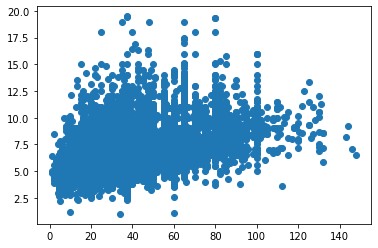

In [51]:
plt.scatter(x=train.ibu, y=train.abv)

### Lets try to model some of these clusters

In [57]:
from sklearn.preprocessing import StandardScaler

def create_cluster(df, X, k):
    
    """ Takes in df, X (dataframe with variables you want to cluster on) and k
    # It scales the X, calcuates the clusters and return dataframe (with clusters), the Scaled dataframe,
    #the scaler and kmeans object and unscaled centroids as a dataframe"""
    
    scaler = StandardScaler(copy=True).fit(X)
    X_scaled = pd.DataFrame(scaler.transform(X), columns=X.columns.values).set_index([X.index.values])
    kmeans = KMeans(n_clusters = k, random_state = 42)
    kmeans.fit(X_scaled)
    kmeans.predict(X_scaled)
    df['cluster'] = kmeans.predict(X_scaled)
    df['cluster'] = 'cluster_' + df.cluster.astype(str)
    centroids = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=X_scaled.columns)
    return df, X_scaled, scaler, kmeans, centroids


def create_scatter_plot(x,y,df,kmeans, X_scaled, scaler):
    
    """ Takes in x and y (variable names as strings, along with returned objects from previous
    function create_cluster and creates a plot"""
    
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x = x, y = y, data = df, hue = 'cluster')
    centroids = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=X_scaled.columns)
    centroids.plot.scatter(y=y, x= x, ax=plt.gca(), alpha=.30, s=500, c='black')

In [65]:
X = train[['ibu', 'srm']]
train, X_scaled, scaler, kmeans, centroids = create_cluster(train, X, 7)


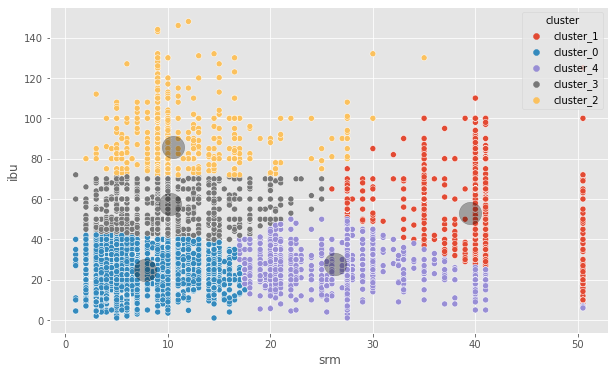

In [120]:
X = train[['ibu', 'srm']]
train, X_scaled, scaler, kmeans, centroids = create_cluster(train, X, 5)
# use the functions I created above to plot the data

create_scatter_plot('srm', 'ibu',train,kmeans, X_scaled, scaler)


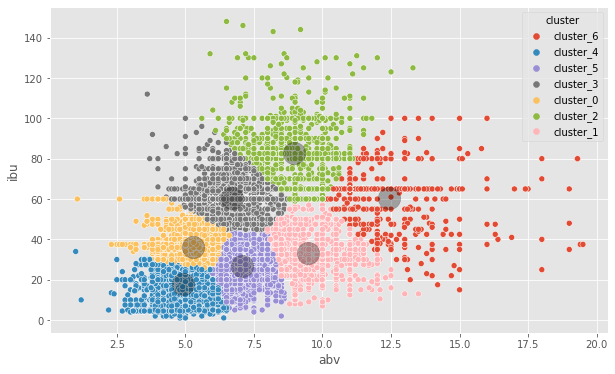

In [118]:
X = train[['ibu', 'abv']]
train, X_scaled, scaler, kmeans, centroids = create_cluster(train, X, 7)
create_scatter_plot('abv', 'ibu',train,kmeans, X_scaled, scaler)

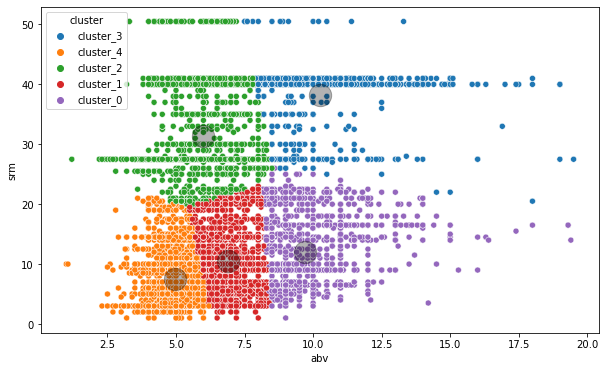

In [90]:
X = train[['srm', 'abv']]
train, X_scaled, scaler, kmeans, centroids = create_cluster(train, X, 5)
create_scatter_plot('abv', 'srm',train,kmeans, X_scaled, scaler)


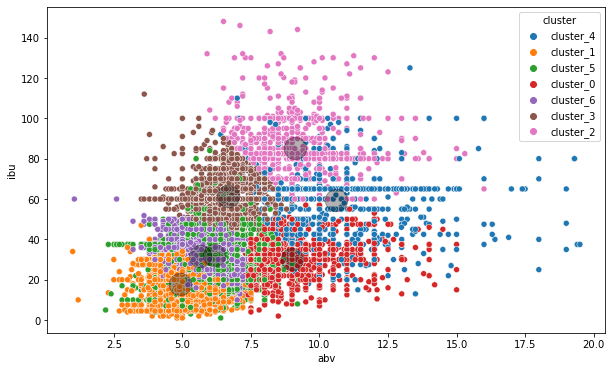

In [92]:
X = train[['srm', 'abv', 'ibu']]
train, X_scaled, scaler, kmeans, centroids = create_cluster(train, X, 7)
create_scatter_plot('abv', 'ibu', train,kmeans, X_scaled, scaler)


ConversionError: Failed to convert value(s) to axis units: ['0', '1', '2', '3', '4', '5', '6', '7']

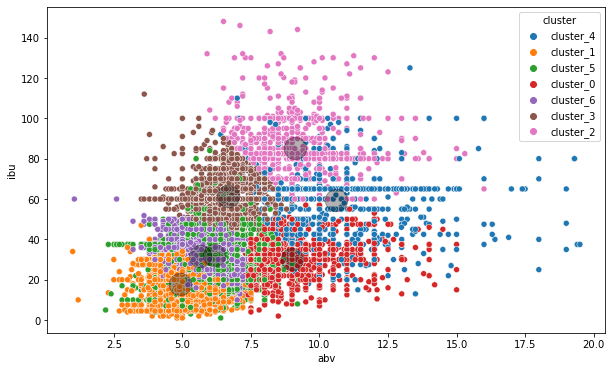

In [93]:
X = train[['srm', 'abv', 'ibu']]
train, X_scaled, scaler, kmeans, centroids = create_cluster(train, X, 7)
create_scatter_plot('abv', 'ibu', train,kmeans, X_scaled, scaler)
plt.xticks(['0','1','2', '3', '4', '5', '6', '7'])


In [77]:
train.columns

Index(['id', 'name', 'nameDisplay', 'abv', 'styleId', 'statusDisplay', 'style',
       'description', 'ibu', 'srm', 'ibu_min', 'ibu_max', 'abv_min', 'abv_max',
       'srm_min', 'srm_max', 'og_min', 'fg_min', 'fg_max', 'category_id',
       'short_name', 'srm_avg', 'ibu_avg', 'abv_avg', 'sour', 'fruit_des',
       'wheat_des', 'smoke_des', 'chili_des', 'mead_des', 'lager_des', 'BBL',
       'american_hop', 'piney_flavor', 'belgian', 'imperial', 'honey',
       'esters', 'bitterness', 'oak', 'style_collapsed', 'scaled_ibu',
       'scaled_srm', 'scaled_abv', 'cluster'],
      dtype='object')

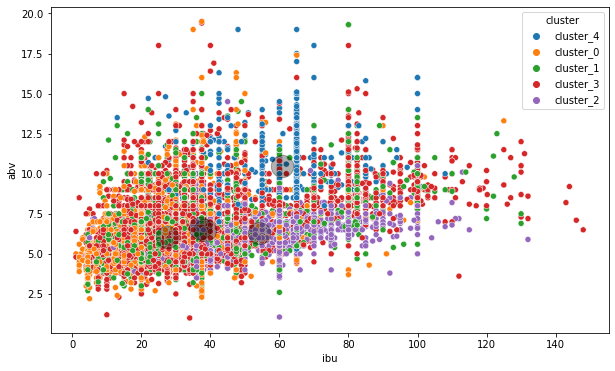

In [83]:
X = train[['sour', 'fruit_des',
       'wheat_des', 'smoke_des', 'chili_des', 'mead_des', 'lager_des', 'BBL',
       'american_hop', 'piney_flavor', 'belgian', 'imperial', 'honey',
       'esters', 'bitterness', 'oak','ibu',
       'srm', 'abv']]

train, X_scaled, scaler, kmeans, centroids = create_cluster(train, X, 5)
create_scatter_plot('ibu', 'abv', train,kmeans, X_scaled, scaler)

In [95]:
df.shape

(26033, 44)

In [97]:
train.shape

(14578, 45)

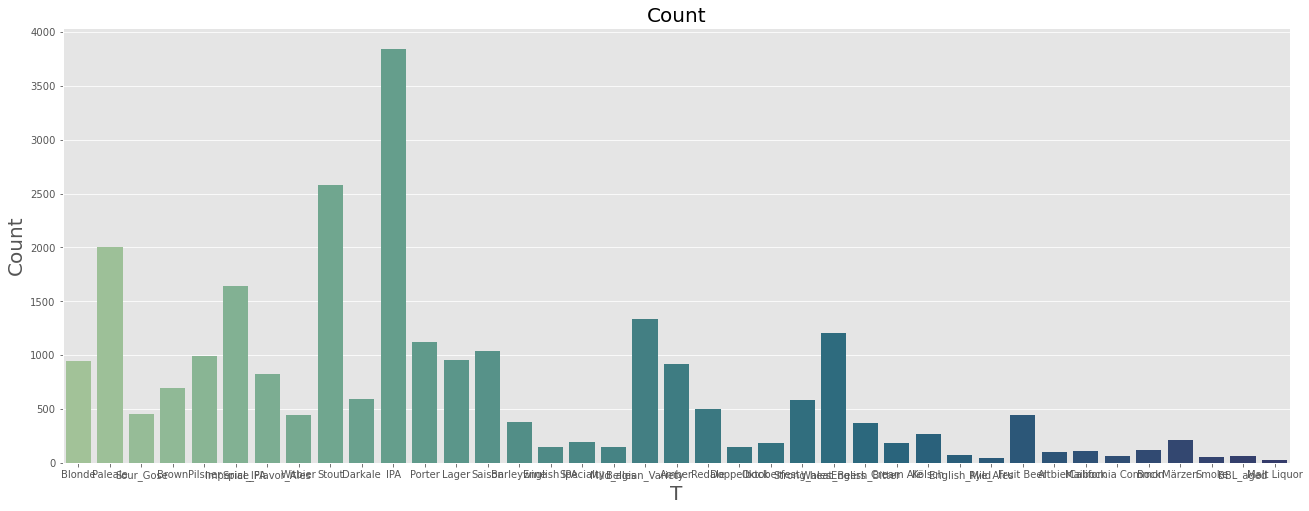

In [130]:
plt.figure(figsize = (22, 8))
sns.countplot(df.style_collapsed, palette=("crest"))
plt.title('Count', fontsize= 20)
plt.xlabel('T', fontsize= 20)
plt.xticks(fontsize = 10)
plt.ylabel('Count', fontsize = 20)
# plt.axhline(y= 32, linestyle= '--')
plt.show()

In [108]:
df.columns

Index(['id', 'name', 'nameDisplay', 'abv', 'styleId', 'statusDisplay', 'style',
       'description', 'ibu', 'srm', 'ibu_min', 'ibu_max', 'abv_min', 'abv_max',
       'srm_min', 'srm_max', 'og_min', 'fg_min', 'fg_max', 'category_id',
       'short_name', 'srm_avg', 'ibu_avg', 'abv_avg', 'sour', 'fruit_des',
       'wheat_des', 'smoke_des', 'chili_des', 'mead_des', 'lager_des', 'BBL',
       'american_hop', 'piney_flavor', 'belgian', 'imperial', 'honey',
       'esters', 'bitterness', 'oak', 'style_collapsed', 'scaled_ibu',
       'scaled_srm', 'scaled_abv'],
      dtype='object')

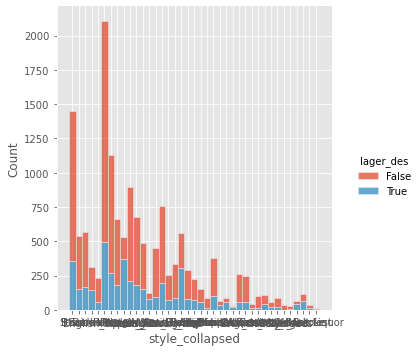

In [113]:
sns.displot(train, x="style_collapsed",hue="lager_des", multiple='stack')
plt.title('')
plt.show();

In [126]:
df1 = df.melt(['style_collapsed', 'ibu', 'srm'])
df1

,style_collapsed,ibu,srm,variable,value
0,Blonde,22.5,5.5,id,soLm3s
1,Paleale,36.0,10.0,id,H1zIi9
2,Sour_Gose,7.0,3.0,id,8BJUmn
3,Brown,35.0,20.5,id,5usK7k
4,Pilsner,50.0,4.5,id,pzy3PL
...,...,...,...,...,...
1067348,Witbier,13.5,3.0,scaled_abv,0.248677
1067349,Cream Ale,15.0,3.5,scaled_abv,0.206349
1067350,Wheat_Beers,12.0,6.0,scaled_abv,0.232804
1067351,Amber,30.0,8.0,scaled_abv,0.179894


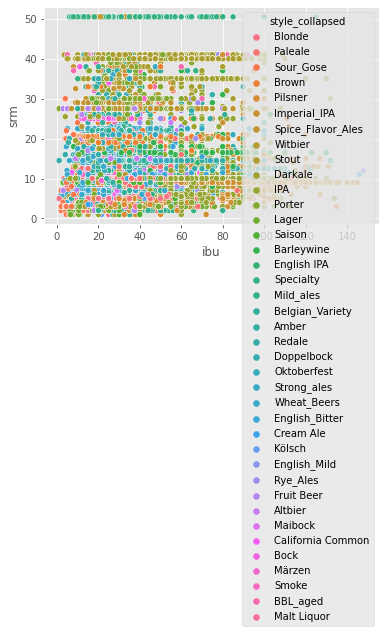

In [127]:
sns.scatterplot(data=df1, x='ibu', y='srm', hue='style_collapsed')
plt.show()

AttributeError: 'PathCollection' object has no property 'height'

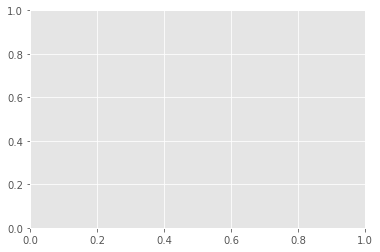

In [129]:
sns.scatterplot(data=df1, x='ibu', y='srm', hue='style_collapsed', height=5, aspect=1.5)
plt.show()

In [102]:

ggplot(df, aes(x='srm', y='ibu')) + geom_point

ModuleNotFoundError: No module named 'plotnine'

In [98]:
plt.style.use('ggplot')
geom_point(data = df, x='srm', y='ibu', hue='style_collapsed')

NameError: name 'geom_point' is not defined